In [21]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Flickr8k/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data'

In [22]:
# LAB 색 체계  : 명도를 나타내는 L채널과 색을 나타내는 A,B 채널
# Let there the color 모델은
# 로 레벨 특징추출기 : 이미지의 국소적인 특징
# 글로벌 레벨 특징추출기 : 전체적인 특징
# 미들 레벨 특징추출기 : 중간크기의 특징
# 컬러라이제이션 신경망 : 특징으로부터 색을 학습
# repeat() 함수 : 텐서를 지정한 차원의 방향으로 복제

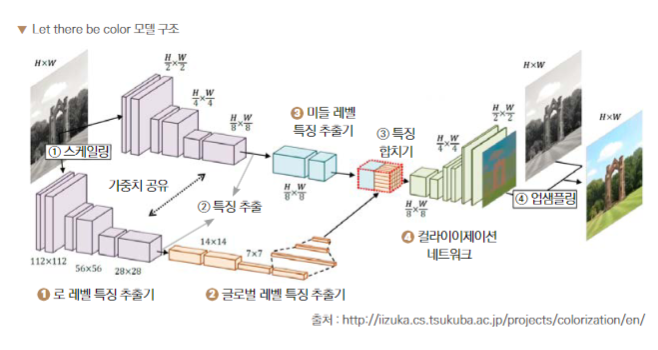

In [23]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
imgs = glob.glob('/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/*.jpg')
imgs[:5]

['/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/394463341_5311c53783.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/380034515_4fbdfa6b26.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/3760400645_3ba51d27f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/3730011701_5352e02286.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/385186343_464f5fc186.jpg']

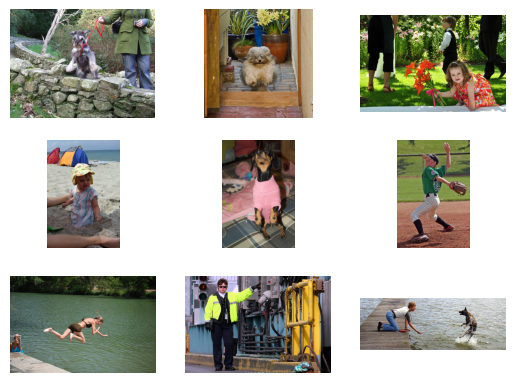

In [24]:
for i in range(9):
  img = Image.open(imgs[i])
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()  

In [25]:
# RGB --> LAB 전처리과정
# opencv cvtColor()함수
# LAB : 이미지의 밝기와 A,B 두 가지 색을 이용해 서 색을 표현
# L채널이 흑백이미지, A채널은 녹색과 적색, B채널은 청색과 노란색
# 

In [26]:
# RGB -> LAB 로 변환하는 함수
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset
def rgb2lab(rgb):
  return cv2.cvtColor(rgb,cv2.COLOR_RGB2LAB)

In [27]:
img = Image.open(imgs[i])
np.array(img).shape , rgb2lab(np.array(img)).shape

((178, 500, 3), (178, 500, 3))

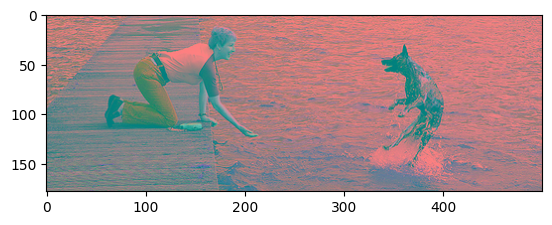

In [28]:
plt.imshow(rgb2lab(np.array(img)))

In [29]:
# 학습용 데이터셋
class AutoColoring(Dataset):
  def __init__(self) -> None:
    self.data = glob.glob('/content/drive/MyDrive/Colab Notebooks/Flickr8k/data/Images/*.jpg')
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    # RGB 이미지 불러오기
    rgb = np.array(Image.open(self.data[index]).resize( (256,256) ) )
    # LAB로 변환
    lab = rgb2lab(rgb)
    # 채널 차원이 가장 앞에 오도록 변경
    lab = lab.transpose( (2,0,1) ).astype(np.float32)
    return lab[0], lab[1:]  # 모델의 입력으로 흑백이미지가 들어가고 L채널이 입력데이터, 색은 AB채널

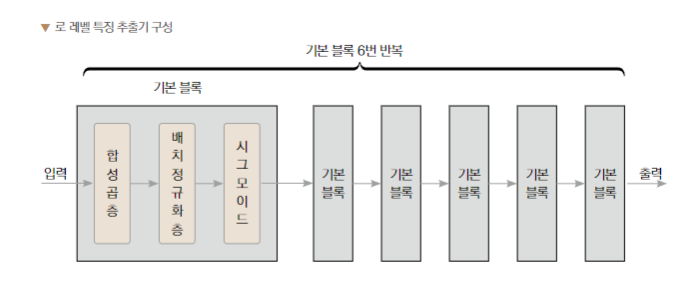

In [30]:
# 로 레벨 측정기
import torch
import torch.nn as nn

In [31]:
class LowLevel(nn.Module):
  def __init__(self):
    super(LowLevel,self).__init__()
    self.low1 = nn.Conv2d(1,64,kernel_size=3,stride=2,padding=1)
    self.lb1 = nn.BatchNorm2d(64)
    self.low2 = nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.lb2 = nn.BatchNorm2d(128)
    self.low3 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.lb3 = nn.BatchNorm2d(128)

    self.low4 = nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.lb4 = nn.BatchNorm2d(256)
    self.low5 = nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1)
    self.lb5 = nn.BatchNorm2d(512)
    self.low6 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.lb6 = nn.BatchNorm2d(512)

    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    low = self.low1(x)
    low = self.lb1(low)
    low = self.sigmoid(low)

    low = self.low2(low)
    low = self.lb2(low)
    low = self.sigmoid(low)

    low = self.low3(low)
    low = self.lb3(low)
    low = self.sigmoid(low)

    low = self.low4(low)
    low = self.lb4(low)
    low = self.sigmoid(low)

    low = self.low5(low)
    low = self.lb5(low)
    low = self.sigmoid(low)

    low = self.low6(low)
    low = self.lb6(low)
    low = self.sigmoid(low)   # 딥러닝에서 특징의 범위를 0과 1사이로 하는게 가장좋다, 로레벨은 미들/글로벌 특징 추출기에서사용
    # 이미지 크기를 점차 줄여 나가야 되기때문에 스트라이드와 패딩을 조정
    return low

In [32]:
class MidLevel(nn.Module):
  def __init__(self):
    super(MidLevel,self).__init__()
    self.mid1 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.mb1 = nn.BatchNorm2d(512)

    self.mid2 = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.mb2 = nn.BatchNorm2d(256)

    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    mid = self.mid1(x)
    mid = self.mb1(mid)
    mid = self.sigmoid(mid)

    mid = self.mid2(x)
    mid = self.mb2(mid)
    mid = self.sigmoid(mid)    
    return mid

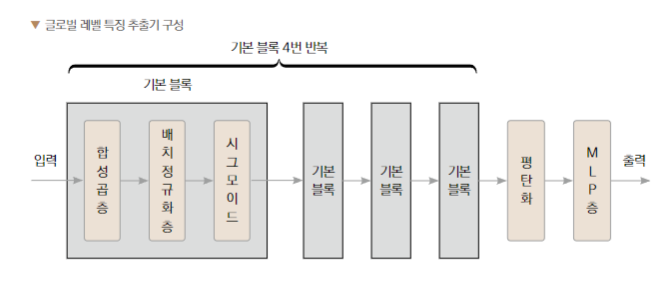

In [33]:
# 글로벌 레벨 특징추출기
class GlobalLevel(nn.Module):
  def __init__(self):
    super(GlobalLevel,self).__init__()
    self.global1 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.gb1 = nn.BatchNorm2d(512)
    self.global2 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.gb2 = nn.BatchNorm2d(512)
    self.global3 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.gb3 = nn.BatchNorm2d(512)
    self.global4 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.gb4 = nn.BatchNorm2d(512)

    # 완전밀집층이긴 하나.. 분류기로서가 아니라.. 색을 칠하기 위해서 사용
    self.fc1 = nn.Linear(in_features= 32768, out_features=1024)
    self.fc2 = nn.Linear(in_features= 1024, out_features=512)
    self.fc3 = nn.Linear(in_features= 512, out_features=256)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    glo = self.global1(x)
    glo = self.gb1(glo)
    glo = self.sigmoid(glo)

    glo = self.global2(glo)
    glo = self.gb2(glo)
    glo = self.sigmoid(glo)

    glo = self.global3(glo)
    glo = self.gb3(glo)
    glo = self.sigmoid(glo)

    glo = self.global4(glo)
    glo = self.gb4(glo)
    glo = self.sigmoid(glo)

    # 추출된 특징을 1차원으로 펼치기
    glo = torch.flatten(glo,start_dim=1)
    glo = self.fc1(glo)
    glo = self.sigmoid(glo)
    glo = self.fc2(glo)
    glo = self.sigmoid(glo)
    glo = self.fc3(glo)
    glo = self.sigmoid(glo)
    return glo

In [34]:
# 컬러라이제이션 신경망
# 색을 칠함
# 합성곱대신에 업샘플링을 사용
# 마지막은 픽셀의 값을 직접 나타내므로 배치정규화나 활성화 함수가 없다

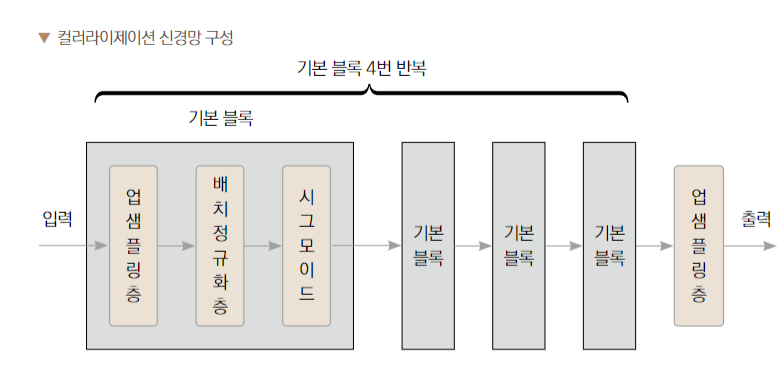

In [35]:
class Colorization(nn.Module):
  def __init__(self):
    super(Colorization,self).__init__()
    self.color1 = nn.ConvTranspose2d(256,128,3,1,1)
    self.cb1 = nn.BatchNorm2d(128)

    self.color2 = nn.ConvTranspose2d(128,64,2,2,0)
    self.cb2 = nn.BatchNorm2d(64)

    self.color3 = nn.ConvTranspose2d(64,64,3,1,1)
    self.cb3 = nn.BatchNorm2d(64)

    self.color4 = nn.ConvTranspose2d(64,32,2,2,0)
    self.cb4 = nn.BatchNorm2d(32)
    self.color5 = nn.ConvTranspose2d(32,2,2,2,0)
    
    self.sigmoid = nn.Sigmoid()
  def forward(self,x ):
    color = self.color1(x)
    color = self.cb1(color)
    color = self.sigmoid(color)

    color = self.color2(color)
    color = self.cb2(color)
    color = self.sigmoid(color)

    color = self.color3(color)
    color = self.cb3(color)
    color = self.sigmoid(color)

    color = self.color4(color)
    color = self.cb4(color)
    color = self.sigmoid(color)

    color = self.color5(color)
    return color

In [36]:
class AutoColoringModel(nn.Module):
  def __init__(self):
    super(AutoColoringModel,self).__init__()
    self.low = LowLevel()
    self.mid = MidLevel()
    self.glob = GlobalLevel()

    # 특징 합치기
    self.fusion = nn.Conv2d(512,256, 3,1,1)
    # 색 입히기
    self.color = Colorization()
    # 활성화 함수
    self.sigmoid = nn.Sigmoid()
  def forward(self,x ):
    low = self.low(x)

    mid = self.mid(low)
    glo = self.glob(low)

    # 글로벌 레벨 추출기의 출력을 미들 레벨 추출기의 출력 크기가 되도록 반복
    fusion = glo.repeat(1, mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(fusion, (-1,256,mid.shape[2], mid.shape[2]))

    # 글로벌 레벨 특징 추출기의 특징, 미들 레벨 특징 추출기의 특징 결합
    fusion = torch.cat([mid,fusion], dim=1)
    fusion = self.fusion(fusion)
    fusion = self.sigmoid(fusion)

    #컬러라이 제이션 신경망
    color = self.color(fusion)
    return color

In [ ]:
from torch.utils.data import dataloader
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoColoringModel().to(device)

dataset = AutoColoring()
loader = DataLoader(dataset,batch_size=32, shuffle=True)
optim = Adam(model.parameters(),lr = 0.01)

for epoch in range(1):
  iterator = tqdm.tqdm(loader)
  for L, AB in iterator:
    # L채널은 흑백이미지 -> 채널 차원을 확보
    L= torch.unsqueeze(L,dim=1).to(device)
    optim.zero_grad()
    pred = model(L)
    loss = nn.MSELoss()(pred, AB.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),"AutoColor.pth")

epoch:0 loss:17372.59765625:   0%|          | 1/253 [00:07<29:44,  7.08s/it]